In [4]:
import logging
import datetime
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import getpass
import seaborn as sns
import copy
import wittgenstein as lw
from schema_buddy import SchemaBuddy
from custom_pipelines import PdFeatureUnion, Pandify, SelectCols, DropCols, TruncOrdinalFreqEncoder, OHE, CategoryFrequency

from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer, QuantileTransformer, RobustScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, precision_recall_curve, auc, roc_auc_score, confusion_matrix
from pandas_profiling import ProfileReport
from janitor import transform_column, rename_columns, filter_column_isin, select_columns, drop_constant_columns

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 101)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
events_df = pd.read_csv("../data/clean_events_v2/events.csv", low_memory=False)

In [6]:
# engineer "is_ranked" feature.
rank_features = [
    "flows_majestic_tpd_rank",
    "flows_umbrella_tpd_rank",
    "flows_majestic_tdurs_rank",
    "flows_umbrella_tdurs_rank",
    "flows_majestic_fqdn_rank",
    "flows_umbrella_fqdn_rank",
    "flows_enterprise_rank",
    "flows_tld_enterprise_rank"
]
events_df["is_ranked"] = events_df[rank_features].sum(axis=1) > 0
events_df["intel_match"] = (events_df["flows_threat_intel_domain_match"] | events_df["flows_threat_intel_ip_match"])

In [7]:
conf = {
    "taget_col": "y_is_malicious",
    "vtype_override": {
        "fk_participant_id": "categorical",
        "category": "categorical",
        "flows_dst_port": "categorical",
        "flows_response": "categorical",
        "flows_methods": "categorical",
        "flows_primary_app_proto": "categorical",
        "flows_dns_distinct_return_codes": "categorical"
    }
}

In [8]:
schema = SchemaBuddy(events_df, conf)

In [9]:
schema.get_styled_variables_summary()

,vtype,is_unique,n_missing,n_distinct,p_distinct,p_zeros,p_negative,vtype_override,dtype
beta,boolean,False,0.000,2.000,0.000,.,.,False,boolean
white_listed,boolean,False,0.000,2.000,0.000,.,.,False,boolean
flows_domain_threat_blacklist,boolean,False,0.000,2.000,0.000,.,.,False,boolean
flows_is_domain_dynamic,boolean,False,0.000,2.000,0.000,.,.,False,boolean
y_is_malicious,boolean,False,0.000,2.000,0.000,.,.,False,boolean
is_ranked,boolean,False,0.000,2.000,0.000,.,.,False,boolean
intel_match,boolean,False,0.000,2.000,0.000,.,.,False,boolean
flows_threat_intel_ip_match,boolean,False,4553.000,2.000,0.000,.,.,False,boolean
flows_dst_is_public_proxy,boolean,False,5320.000,2.000,0.000,.,.,False,boolean
flows_tld_check,boolean,False,7525.000,2.000,0.000,.,.,False,boolean


In [10]:
events_df.shape

(111606, 53)

In [11]:
events_df["y_is_malicious"].value_counts()

False    110773
True        833
Name: y_is_malicious, dtype: int64

# EDA by column type

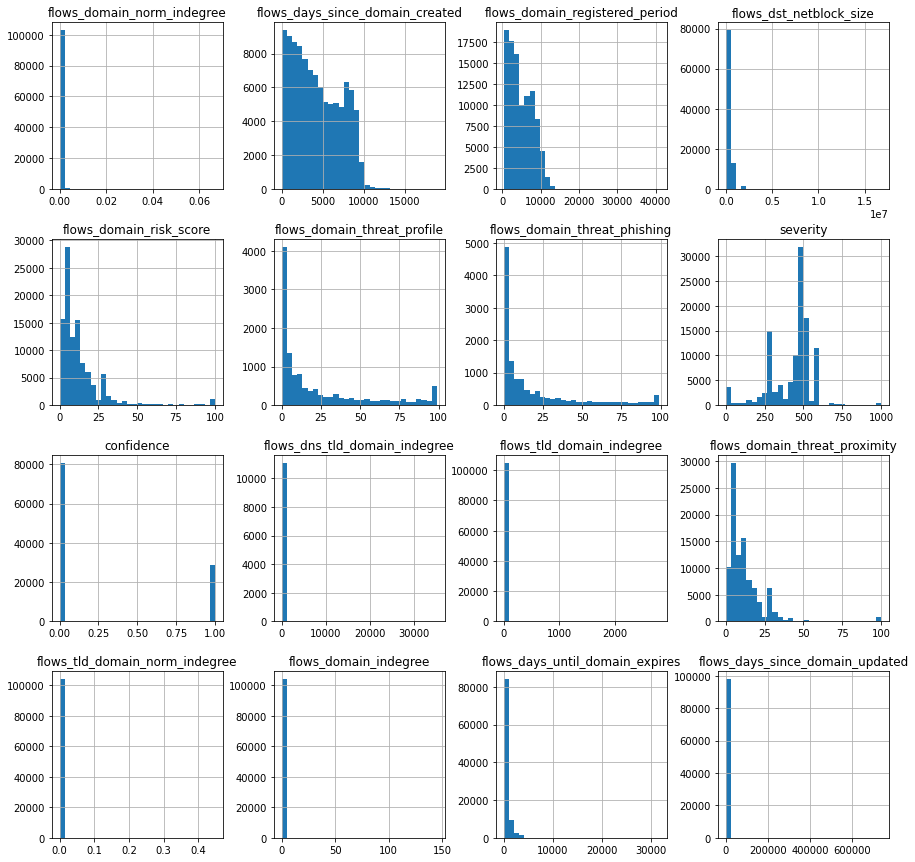

In [12]:
# distibution of contiuous values

numeric_slim = set(schema.get_cols("numeric")) - set(rank_features)

events_df[numeric_slim].hist(figsize=(15, 15), bins = 30)
plt.show()

In [13]:
# confidence values by subcategory
events_df.groupby(["sub_category"]).agg({"confidence": ["min", "max", "median", "mean", pd.Series.nunique]}).sort_values(("confidence", "nunique"))

confidence                                   
                                   min       max median      mean nunique
sub_category                                                             
CREDENTIAL_PHISHING                0.0  0.500000    0.0  0.060956     2.0
DNS_TUNNELING                      0.0  1.000000    0.0  0.052705     2.0
DOMAIN_ANALYSIS_HTTP               0.0  1.000000    0.0  0.295204     2.0
DOMAIN_ANALYSIS_TLS                0.0  1.000000    0.0  0.279105     2.0
SUSPICIOUS_FILE_DOWNLOADS          0.0  0.500000    0.0  0.089286     2.0
TLS_INVALID_CERT_CHAIN             0.0  1.000000    0.0  0.140075     2.0
CONSISTENT_BEACONING_HTTP          0.0  1.000000    0.0  0.159690   371.0
CONSISTENT_BEACONING_TLS           0.0  1.000000    0.0  0.123532   519.0
DOMAIN_GENERATION_ALGORITHM        0.0  0.999998    0.0  0.265863  1070.0

In [14]:
def get_na_prop(df):
    """Return the proportion of each column from a dataframe that are na"""
    return (df.apply(pd.isna).sum() / len(df)).sort_values(ascending = False)

def get_zero_prop(df):
    """Return the proportion of each column from a dataframe that are zero or false"""
    return (df.apply(lambda x: x == 0.0).sum() / len(df)).sort_values(ascending = False)


def missing_value_dist(df, include_zeros=False):
    na_props = get_na_prop(df).to_frame("na_props")
    zero_props = get_zero_prop(df).to_frame("zero_props")
    missing_vals_df = na_props.join(zero_props)
    
    missing_vals_df["sum"] = missing_vals_df.sum(axis=1)
    missing_vals_df.sort_values("sum", inplace=True)

    plt.figure(figsize=(15, len(missing_vals_df)/2))
    plt.xlim(0, 1)
    plt.barh(missing_vals_df.index, missing_vals_df["na_props"], label='is na')
    
    if include_zeros:
        plt.barh(missing_vals_df.index, missing_vals_df["zero_props"], label='is zero', left=missing_vals_df["na_props"])

    plt.legend()
    plt.show()

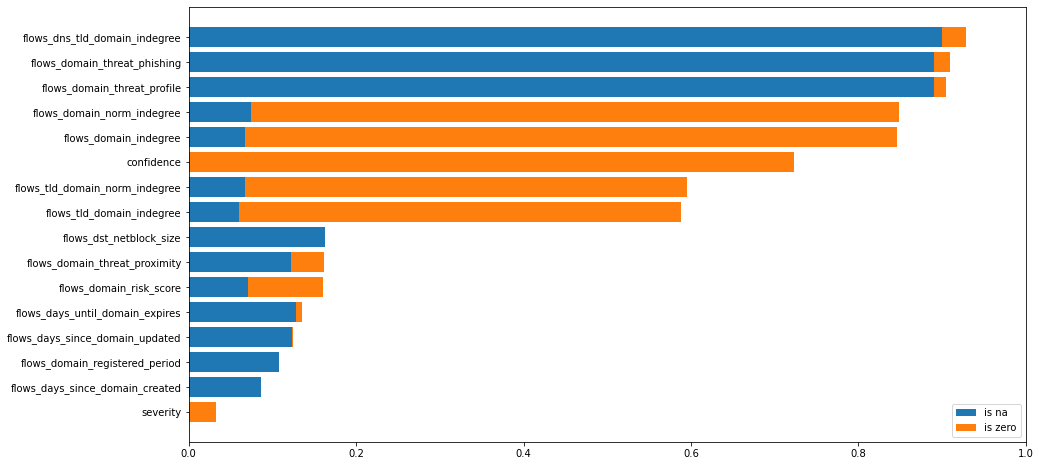

In [15]:
missing_value_dist(events_df[numeric_slim], True)

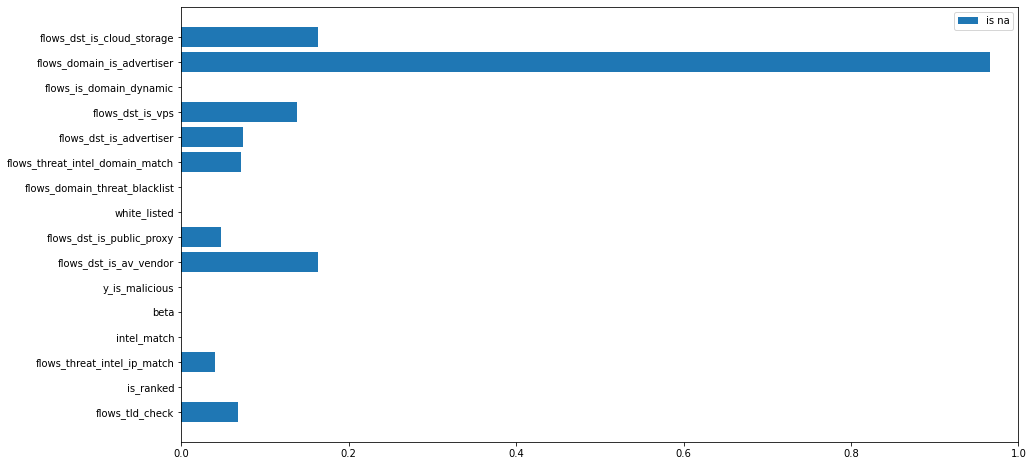

In [16]:
# missing values for binary columns
missing_value_dist(events_df[schema.get_cols("boolean")], False)

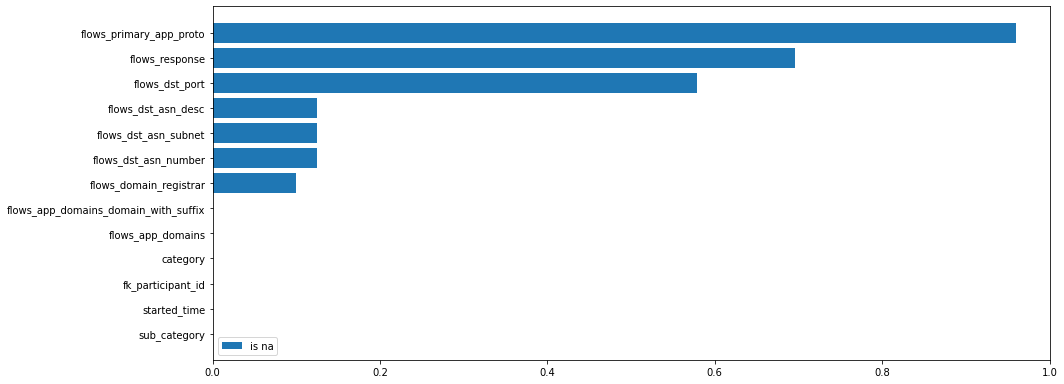

In [17]:
missing_value_dist(events_df[schema.get_cols("categorical")], False)

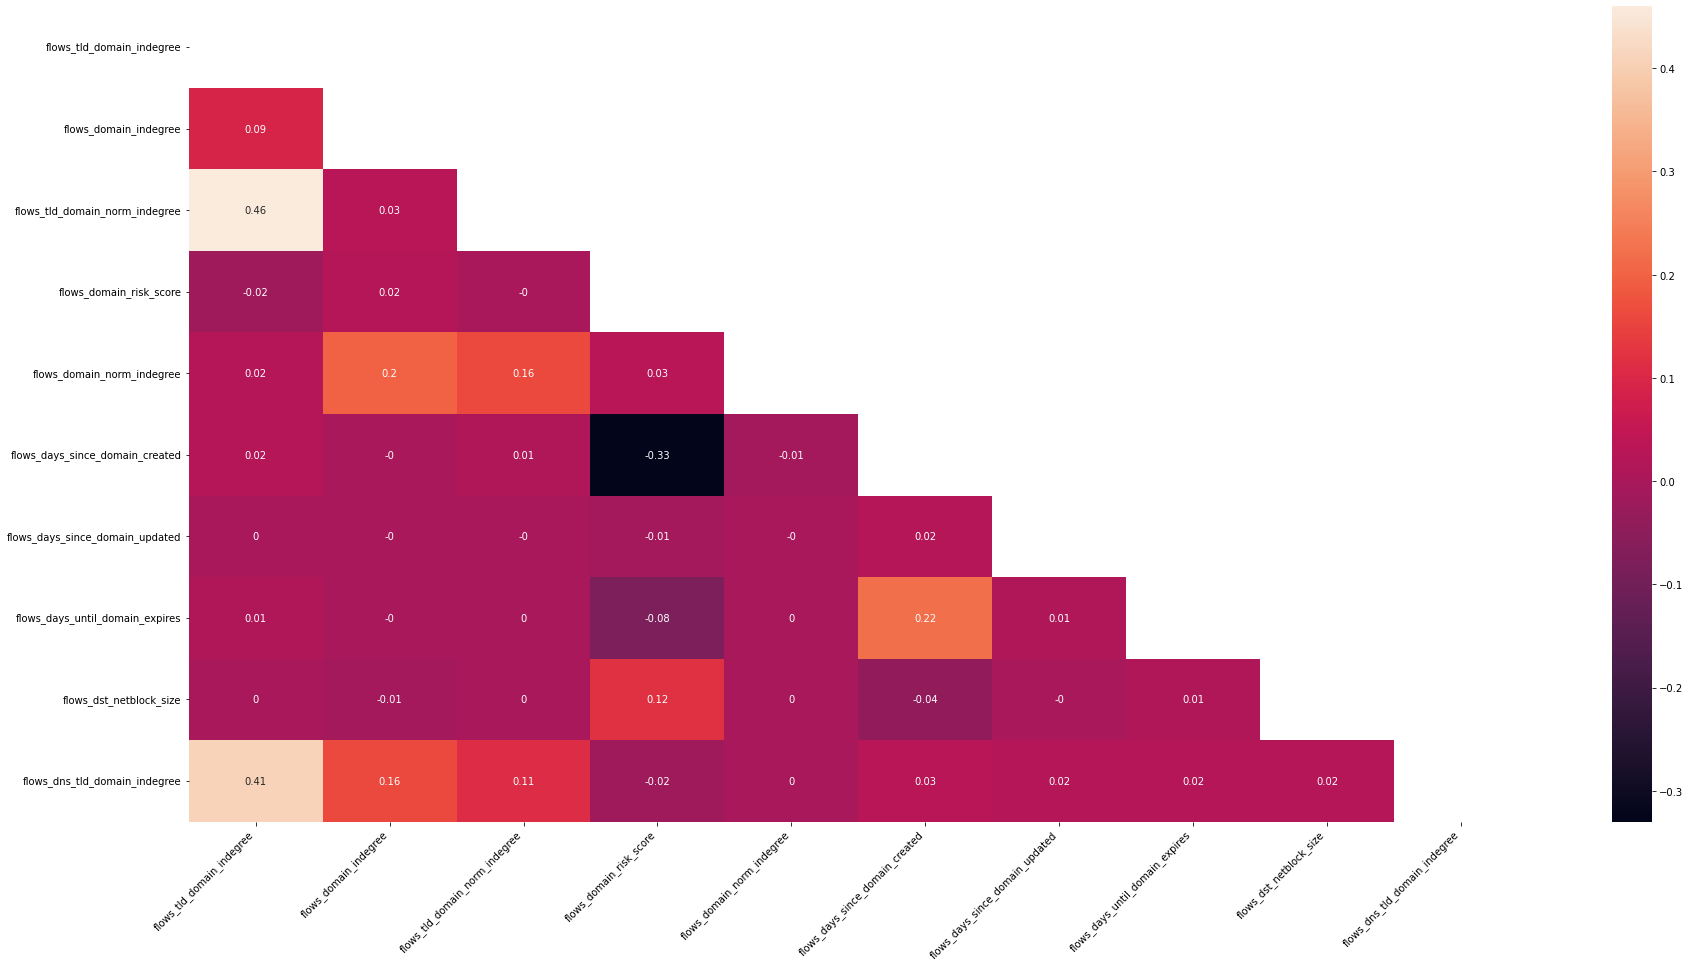

In [18]:
# look at linear correlation of features
bookkeeper = schema.get_bookkeeper()
bookkeeper.pop_cols([        
    "beta",
    "severity",
    "category",
    "confidence",
    "sub_category",
    "started_time",
    "fk_participant_id",
    "flows_dst_port",
    "flows_app_domains",
    "flows_app_domains_domain_with_suffix",
    "flows_domain_registered_period",
    "flows_domain_threat_profile",
    "flows_domain_threat_phishing",
    "flows_domain_threat_proximity"
] + rank_features)

use_cols = bookkeeper.pop_vtype("numeric")

plt.figure(figsize=(30,15))
corr = events_df[use_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr.round(2), annot=True, mask=mask)
plt.xticks(rotation=45, ha="right")
plt.show()

In [19]:
def get_feature_preprocessor(schema):
    # TODO features indicating if value was imputed
    bookkeeper = schema.get_bookkeeper()
    
    drop_list = [
        "beta",
        "severity",
        "category",
        "confidence",
        "sub_category",
        "started_time",
        "fk_participant_id",
        "flows_dst_port",
        "flows_app_domains",
        "flows_app_domains_domain_with_suffix",
        "flows_domain_registered_period",
        "flows_domain_threat_profile",  # highly correlated
        "flows_domain_threat_phishing", # highly correlated
        "flows_domain_threat_proximity", # highly correlated
        "flows_threat_intel_domain_match",
        "flows_threat_intel_ip_match",        
    ] + rank_features
    
    num_passthrough_list = [
        "flows_tld_domain_norm_indegree",
        "flows_domain_norm_indegree",
    ]
    
    bookkeeper.pop_cols(drop_list)
    
    preprocessor = Pipeline([
        ('union', PdFeatureUnion([
            ('num_pass', Pipeline([
                ('select', SelectCols(bookkeeper.pop_cols(num_passthrough_list), strict=False)),
                ('impute', Pandify(SimpleImputer(strategy="constant", fill_value=0.0)))
            ])),
            ('num', Pipeline([
                ('select', SelectCols(bookkeeper.pop_vtype("numeric"), strict=False)),
                ('scale', Pandify(QuantileTransformer())),
                ('impute', Pandify(SimpleImputer(strategy="constant", fill_value=0.0)))
            ])),
            ('bool', Pipeline([
                ('select', SelectCols(bookkeeper.pop_vtype("boolean"), strict=False)),
                ('bool2float', Pandify(FunctionTransformer(lambda x: pd.DataFrame(x).astype(float)))),
                ('impute', Pandify(SimpleImputer(strategy="constant", fill_value=0.0)))
            ])),
            ('cat', Pipeline([
                ('select', SelectCols(bookkeeper.pop_vtype("categorical"), strict=False)),
                ('cat2freq', CategoryFrequency(use_proportion=True)),
                ('impute', Pandify(SimpleImputer(strategy="constant", fill_value=0.0))),
            ])),
        ])), # close feature union
    ]) # close pipeline
    
    bookkeeper.check()
    
    return preprocessor

In [20]:
def get_xy(df, target_col, maj_nsamples=None):
    df[target_col] = df[target_col].astype(float)

    if maj_nsamples:
        # what happens when we down sample the majority class?
        rus = RandomUnderSampler(sampling_strategy={0: maj_nsamples}, random_state=1)
        df_balanced, balanced_labels = rus.fit_resample(df, df[target_col])

        X = df_balanced.drop(target_col, axis=1)
        y = df_balanced[target_col].values
        return X, y
    
    else:
        X = df.drop(target_col, axis=1)
        y = df[target_col].values
        return X, y

In [21]:
def cross_val_results(models, preprocessor, X, y, cv, predict_probs=True):
    """Pass in a list of sklearn pipelines"""
    model_results = []

    for model_name, model in models.items():
        print(model_name)
        for train_index, val_index in cv.split(X, y):

            # break apart test and train for this cv split
            X_train = X.iloc[train_index, :]
            X_val = X.iloc[val_index, :]
            y_train = y[train_index]
            y_val = y[val_index]

            # fit on train and predict on val
            X_train_clean = preprocessor.fit_transform(X_train)
            X_val_clean = preprocessor.transform(X_val)
            model.fit(X_train_clean, y_train)
            y_preds = model.predict(X_val_clean)
            y_probs = None if not predict_probs else model.predict_proba(X_val_clean)[:, 1]

            model_result = score_preds(y_val, y_preds, y_probs, predict_probs)
            model_result["model_name"] = model_name
            model_results.append(model_result)
            
    return model_results


def score_preds(y_actual, y_preds, y_probs=None, has_probs=False):
    model_result = {}
    model_result["recall"] = recall_score(y_actual, y_preds)
    model_result["precision"] = precision_score(y_actual, y_preds)
    model_result["accuracy"] = accuracy_score(y_actual, y_preds)
    model_result["f1"] = f1_score(y_actual, y_preds)
    tn, fp, fn, tp = confusion_matrix(y_actual, y_preds).ravel()
    model_result["tn"] = tn
    model_result["fp"] = fp
    model_result["fn"] = fn
    model_result["tp"] = tp
    
    if has_probs:
        model_result["auc_roc"] = roc_auc_score(y_actual, y_probs)
        pr_curve = precision_recall_curve(y_actual, y_probs)
        model_result["pr_curve"] = pr_curve
        model_result["pr_curve_auc"] = auc(pr_curve[1], pr_curve[0])
        
    return model_result

In [22]:
X, y = get_xy(events_df, "y_is_malicious")
preprocessor = get_feature_preprocessor(schema)
cv = StratifiedShuffleSplit(n_splits=5, random_state=42)

All cols accounted


In [23]:
preprocessor.fit_transform(X).shape

(111606, 28)

In [24]:
models = {}
models["LR_l1"] = LogisticRegression(penalty="l1", max_iter=1000, solver="saga")
models["LR_l2"] = LogisticRegression(penalty="l2", max_iter=300)
models["LR"] = LogisticRegression(max_iter=300)

In [25]:
regression_results = cross_val_results(models, preprocessor, X, y, cv)

LR_l1
LR_l2
LR


In [26]:
def get_results_df(model_results):
    # dump model results into a dataframe
    results_data = []
    for model in model_results:
        results_data.append((model.values()))
    return pd.DataFrame(results_data, columns = model_results[0].keys())

In [27]:
regression_results_df = get_results_df(regression_results)

In [28]:
regression_results_df.groupby("model_name").mean().sort_values("precision")

,recall,precision,accuracy,f1,tn,fp,fn,tp,auc_roc,pr_curve_auc
model_name,,,,,,,,,,
LR_l1,0.093976,0.475704,0.992492,0.156332,11069.4,8.6,75.2,7.8,0.972834,0.302122
LR,0.079518,0.490192,0.992528,0.136475,11071.0,7.0,76.4,6.6,0.973281,0.290021
LR_l2,0.079518,0.490192,0.992528,0.136475,11071.0,7.0,76.4,6.6,0.973288,0.290151


In [29]:
def plot_pr_curves(results_df):
    models = results_df["model_name"].unique()
    
    fig, ax = plt.subplots(len(models), int(len(results_df) / len(models)), figsize=(30, 15))
    
    for row_num in range(len(models)):
        model = models[row_num]
        curves = results_df.loc[results_df["model_name"] == model, "pr_curve"].values
        
        for col_num in range(len(curves)):
            
            curve = curves[col_num]
            ax[row_num, col_num].plot(curve[1], curve[0])
            ax[row_num, col_num].set_title(model)
            ax[row_num, col_num].set_xlabel("recall")
            ax[row_num, col_num].set_ylabel("precision")
            ax[row_num, col_num].hlines(.03, 0, 1, color="r", ls = "--")
    plt.show()

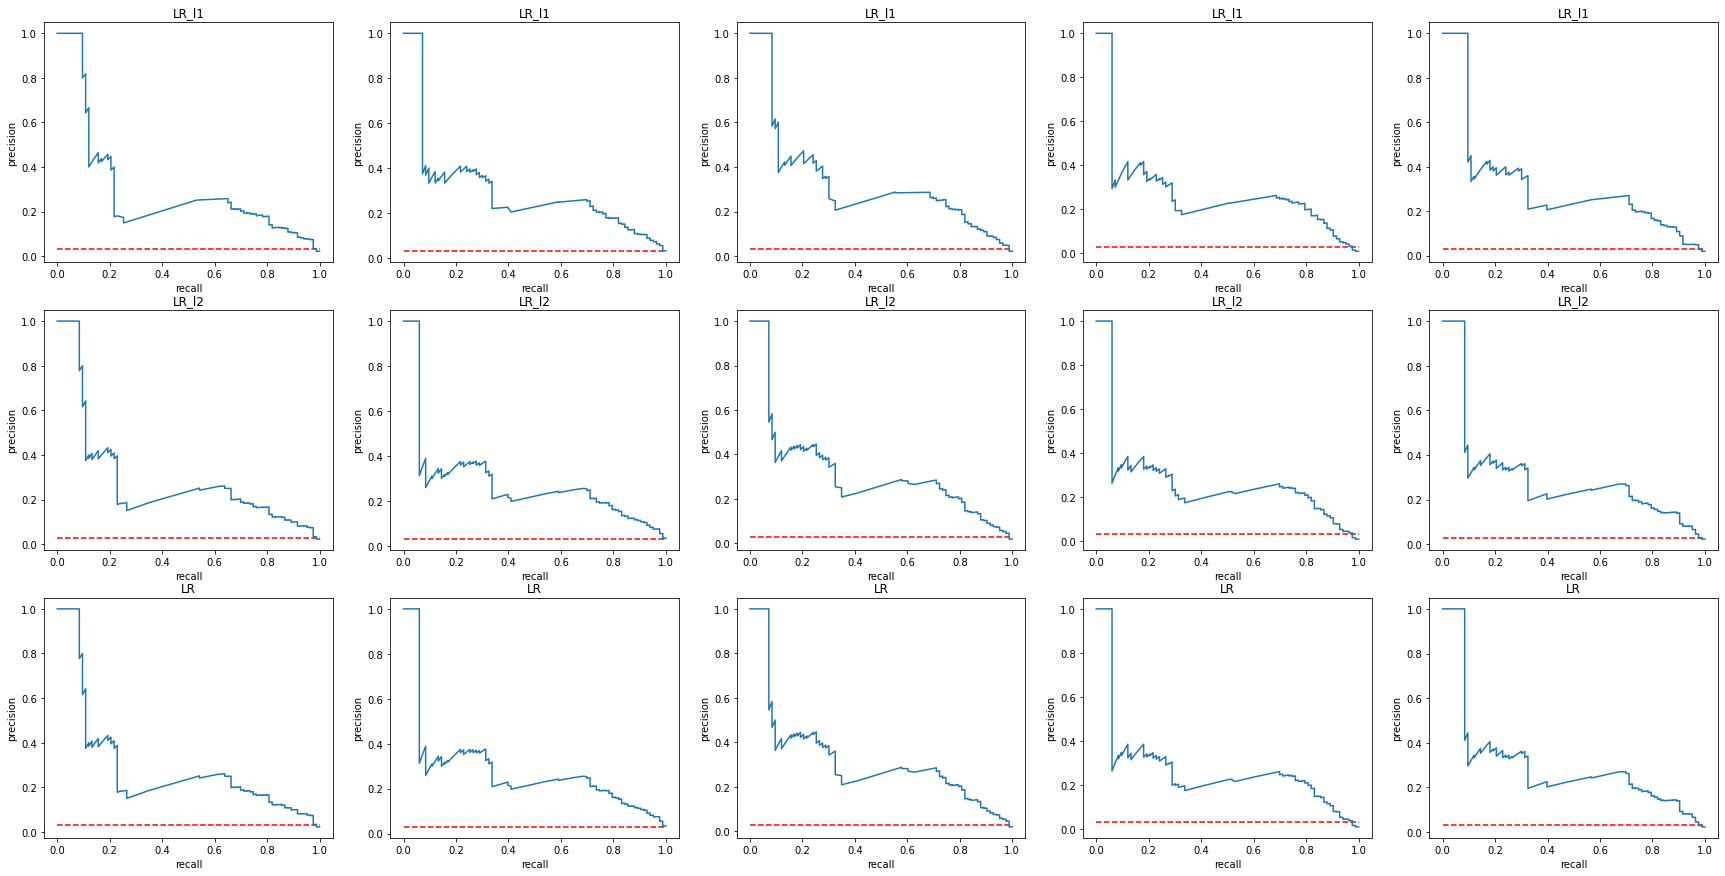

In [30]:
plot_pr_curves(regression_results_df)

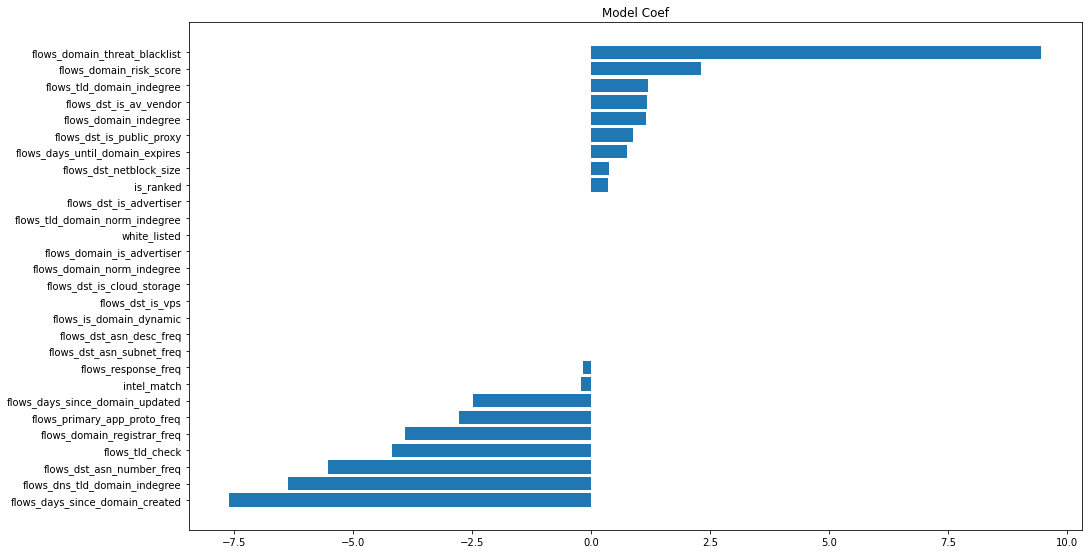

In [31]:
# get feature coefs for specific LR model fit to all data
X_clean = preprocessor.fit_transform(X, y)
clf = models["LR_l1"]
clf.fit(X_clean, y)

coef_df = pd.DataFrame({"feature": X_clean.columns, "coef": clf.coef_[0]}).sort_values("coef")

plt.figure(figsize=(16, int(len(coef_df))/3))
plt.barh(coef_df["feature"], coef_df["coef"])
plt.title("Model Coef")
plt.show()

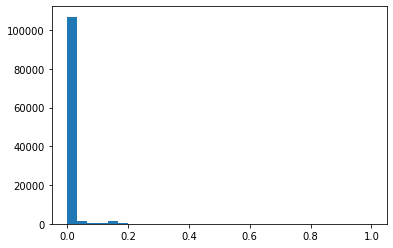

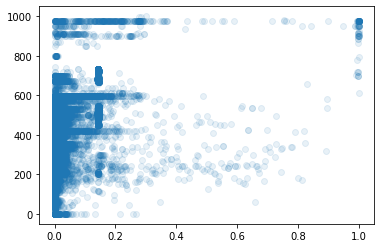

In [32]:
plt.hist(clf.predict_proba(X_clean)[:, 1], bins = 30)
plt.show()
plt.scatter(clf.predict_proba(X_clean)[:, 1], X["severity"], alpha=.1)
plt.show()

### domain norm indegree

In [33]:
X["flows_tld_domain_norm_indegree"].apply(pd.isna).value_counts()

False    104061
True       7545
Name: flows_tld_domain_norm_indegree, dtype: int64

In [34]:
# very right skewed
X["flows_tld_domain_norm_indegree"].round(3).value_counts().sort_index().head(15)

0.000    98906
0.001     3363
0.002       94
0.003     1088
0.004       54
0.005       53
0.006       59
0.007       14
0.008       42
0.009      150
0.010       80
0.011        9
0.012        8
0.013        2
0.014       18
Name: flows_tld_domain_norm_indegree, dtype: int64

# Decision Trees

In [35]:
def get_feature_preprocessor(schema):
    # TODO features indicating if value was imputed
    bookkeeper = schema.get_bookkeeper()
    
    drop_list = [
        "beta",
        "severity",
        "category",
        "confidence",
        "sub_category",
        "started_time",
        "fk_participant_id",
        "flows_dst_port",
        "flows_app_domains",
        "flows_app_domains_domain_with_suffix",
        "flows_domain_registered_period",
        "flows_domain_threat_profile",  # highly correlated
        "flows_domain_threat_phishing", # highly correlated
        "flows_domain_threat_proximity", # highly correlated
        "flows_threat_intel_domain_match",
        "flows_threat_intel_ip_match",
    ] + rank_features
    
    bookkeeper.pop_cols(drop_list)
    
    preprocessor = Pipeline([
        ('union', PdFeatureUnion([
            ('num', Pipeline([
                ('select', SelectCols(bookkeeper.pop_vtype("numeric"), strict=False)),
                ('impute', Pandify(SimpleImputer(strategy="constant", fill_value=-1.0)))
            ])),
            ('bool', Pipeline([
                ('select', SelectCols(bookkeeper.pop_vtype("boolean"), strict=False)),
                ('bool2float', Pandify(FunctionTransformer(lambda x: pd.DataFrame(x).astype(float)))),
                ('impute', Pandify(SimpleImputer(strategy="constant", fill_value=-1.0)))
            ])),
            ('cat', Pipeline([
                ('select', SelectCols(bookkeeper.pop_vtype("categorical"), strict=False)),
                ('cat2freq', CategoryFrequency(use_proportion=True)),
                ('impute', Pandify(SimpleImputer(strategy="constant", fill_value=-1.0))),
            ])),
        ])), # close feature union
    ]) # close pipeline
    
    bookkeeper.check()
    
    return preprocessor

In [36]:
X, y = get_xy(events_df, "y_is_malicious")

In [37]:
models = {}
models["dt_md2"] = DecisionTreeClassifier(max_depth=2)
models["dt_md3"] = DecisionTreeClassifier(max_depth=3)
models["dt_md4"] = DecisionTreeClassifier(max_depth=4)
models["dt_md5"] = DecisionTreeClassifier(max_depth=5)

In [38]:
preprocessor = get_feature_preprocessor(schema)
dt_results = cross_val_results(models, preprocessor, X, y, cv)

All cols accounted
dt_md2
dt_md3
dt_md4
dt_md5


In [39]:
dt_results_df = get_results_df(dt_results)
dt_results_df.groupby("model_name").mean().sort_values("pr_curve_auc")

,recall,precision,accuracy,f1,tn,fp,fn,tp,auc_roc,pr_curve_auc
model_name,,,,,,,,,,
dt_md2,0.460241,0.603561,0.993710,0.521264,11052.6,25.4,44.8,38.2,0.975582,0.525208
dt_md3,0.306024,0.701613,0.993818,0.421953,11066.6,11.4,57.6,25.4,0.983275,0.589704
dt_md4,0.366265,0.676786,0.993889,0.466133,11062.4,15.6,52.6,30.4,0.984818,0.621243
dt_md5,0.749398,0.634334,0.994893,0.685399,11041.8,36.2,20.8,62.2,0.977366,0.644950


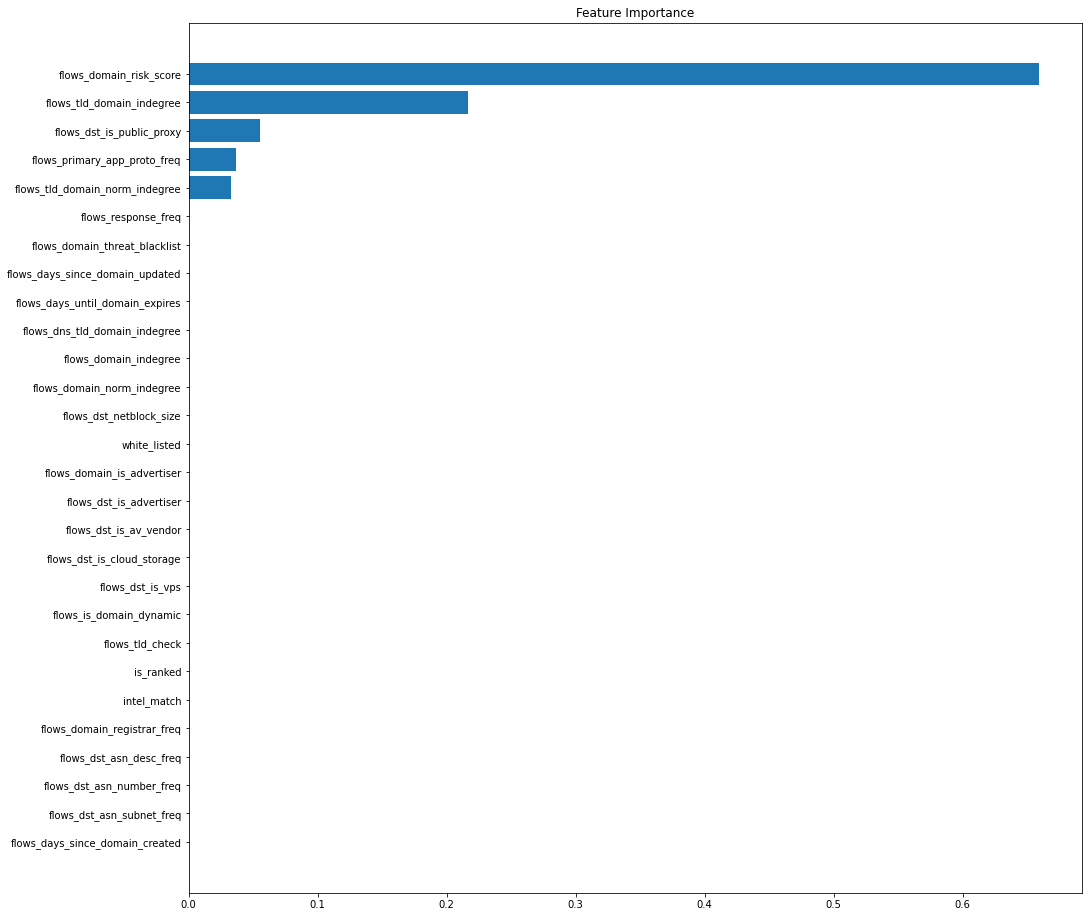

In [40]:
# get feature coefs for specific LR model fit to all data
X_clean = preprocessor.fit_transform(X)
clf = models["dt_md3"]
clf.fit(X_clean, y)

coef_df = pd.DataFrame({"feature": X_clean.columns, "feature_importance": clf.feature_importances_}).sort_values("feature_importance")

plt.figure(figsize=(16, 16))
plt.barh(coef_df["feature"], coef_df["feature_importance"])
plt.title("Feature Importance")
plt.show()

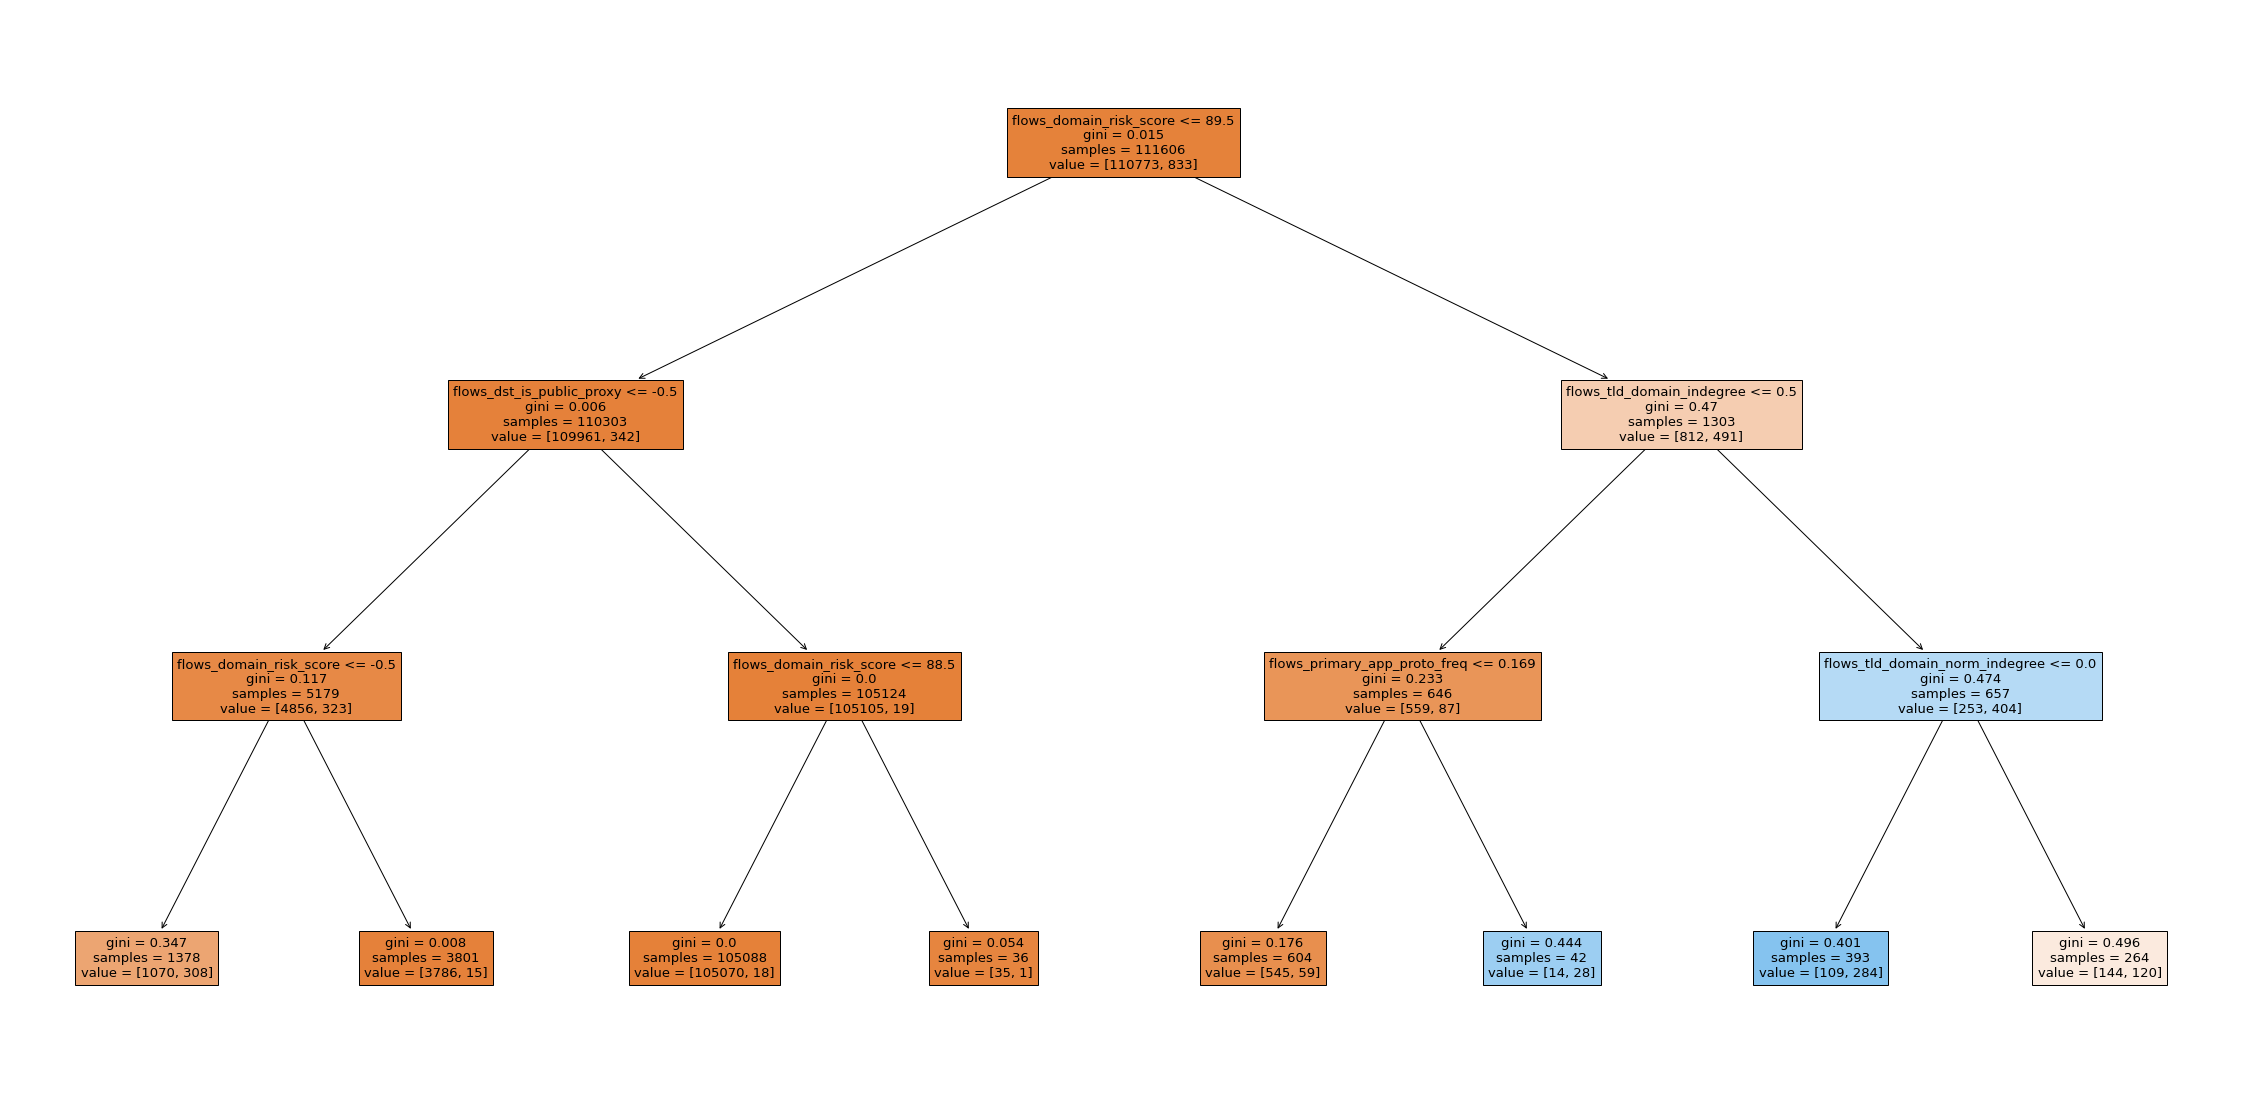

In [41]:
plt.figure(figsize=(40,20))
tree.plot_tree(clf, feature_names=X_clean.columns, filled=True)
plt.show()

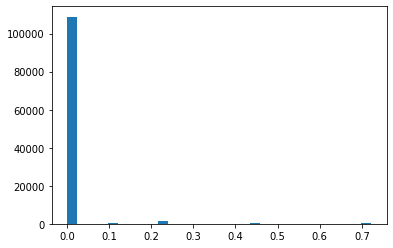

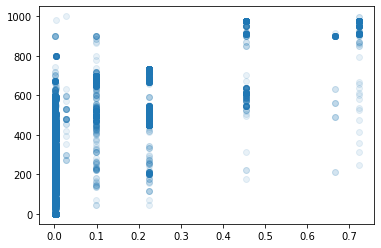

In [42]:
plt.hist(clf.predict_proba(X_clean)[:, 1], bins = 30)
plt.show()
plt.scatter(clf.predict_proba(X_clean)[:, 1], X["severity"], alpha=.1)
plt.show()

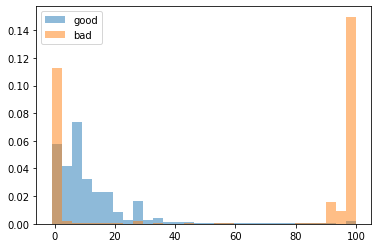

In [43]:
plt.hist(X_clean.loc[y == 0, "flows_domain_risk_score"], density=True, alpha = .5, label = 'good', bins = 30)
plt.hist(X_clean.loc[y == 1, "flows_domain_risk_score"], density=True, alpha = .5, label = 'bad', bins = 30)
plt.legend()
plt.show()

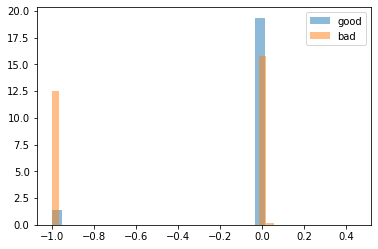

In [44]:
plt.hist(X_clean.loc[y == 0, "flows_tld_domain_norm_indegree"], density=True, alpha = .5, label = 'good', bins = 30)
plt.hist(X_clean.loc[y == 1, "flows_tld_domain_norm_indegree"], density=True, alpha = .5, label = 'bad', bins = 30)
plt.legend()
plt.show()

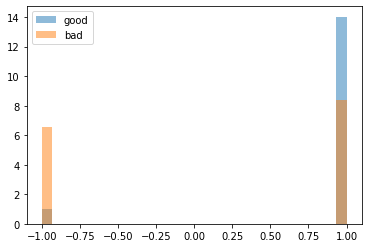

In [45]:
plt.hist(X_clean.loc[y == 0, "flows_tld_check"], density=True, alpha = .5, label = 'good', bins = 30)
plt.hist(X_clean.loc[y == 1, "flows_tld_check"], density=True, alpha = .5, label = 'bad', bins = 30)
plt.legend()
plt.show()